# Part 1. Tutorial of Bayesian Models with Pgmpy

Pgmpy is a pure python implementation for Probabilistic Graphical Models (Bayesian Networks) with a focus on modularity and extensibility. Implementations of various alogrithms for Structure Learning, Parameter Estimation, Approximate (Sampling Based) and Exact inference, and Causal Inference are available. Official site: http://pgmpy.org. 

Below is a modified verison of the official tutorial (https://github.com/pgmpy/pgmpy_notebook).

### Install PgmPy

In [1]:
%%capture
!pip install pgmpy

## 1. Bayesian Networks: Representing and Inference

### 1.1 What are Bayesian Models
A Bayesian network (Bayes network, belief network, Bayes(ian) model or probabilistic directed acyclic graphical model) is a probabilistic graphical model (a type of statistical model) that represents a set of random variables and their conditional dependencies via a directed acyclic graph (DAG). 

Bayesian networks are mostly used when we want to represent causal relationship between the random variables. 

Bayesian Networks are parameterized using Conditional Probability Distributions (CPD). Each node in the network is parameterized using $P(node | Pa(node))$ where $Pa(node)$ represents the parents of node in the network.

We can take the example of the student model with five random variables in this domain:

- the course difficulty (D),
- the student's intelligence (I),
- the grade (G),
- the student's SAT score (S),
- and the quality of the recommendation letter(L).

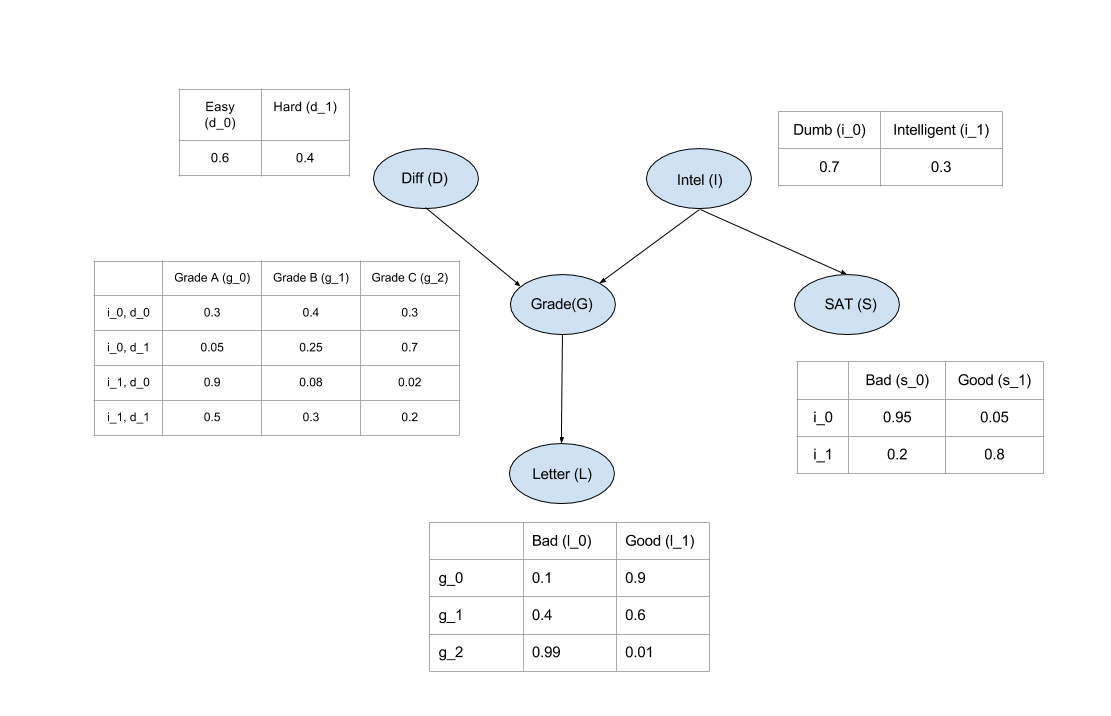

In pgmpy we define the network structure and the CPDs separately and then associate them with the structure. Here's an example for defining the above model:

In [2]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

# Defining the model structure. We can define the network by just passing a list of edges.
model = BayesianNetwork([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])

# Defining individual CPDs.
cpd_d = TabularCPD(variable='D', variable_card=2, values=[[0.6], [0.4]], state_names={'D': ['Easy', 'Hard']})
cpd_i = TabularCPD(variable='I', variable_card=2, values=[[0.7], [0.3]], state_names={'I': ['Dumb', 'Intelligent']})


# The representation of CPD in pgmpy is a bit different than the CPD shown in the above picture. In pgmpy the colums
# are the evidences and rows are the states of the variable. So the grade CPD is represented like this:
#
#    +---------+---------+---------+---------+---------+
#    | diff    | intel_0 | intel_0 | intel_1 | intel_1 |
#    +---------+---------+---------+---------+---------+
#    | intel   | diff_0  | diff_1  | diff_0  | diff_1  |
#    +---------+---------+---------+---------+---------+
#    | grade_0 | 0.3     | 0.05    | 0.9     | 0.5     |
#    +---------+---------+---------+---------+---------+
#    | grade_1 | 0.4     | 0.25    | 0.08    | 0.3     |
#    +---------+---------+---------+---------+---------+
#    | grade_2 | 0.3     | 0.7     | 0.02    | 0.2     |
#    +---------+---------+---------+---------+---------+

cpd_g = TabularCPD(variable='G', variable_card=3, 
                   values=[[0.3, 0.05, 0.9,  0.5],
                           [0.4, 0.25, 0.08, 0.3],
                           [0.3, 0.7,  0.02, 0.2]],
                  evidence=['I', 'D'],
                  evidence_card=[2, 2],
                  state_names={'G': ['A', 'B', 'C'],
                                   'I': ['Dumb', 'Intelligent'],
                                   'D': ['Easy', 'Hard']})

cpd_l = TabularCPD(variable='L', variable_card=2, 
                   values=[[0.1, 0.4, 0.99],
                           [0.9, 0.6, 0.01]],
                   evidence=['G'],
                   evidence_card=[3],
                   state_names={'L': ['Bad', 'Good'],
                                   'G': ['A', 'B', 'C']})

cpd_s = TabularCPD(variable='S', variable_card=2,
                   values=[[0.95, 0.2],
                           [0.05, 0.8]],
                   evidence=['I'],
                   evidence_card=[2],
                   state_names={'S': ['Bad', 'Good'],
                                'I': ['Dumb', 'Intelligent']})

# Associating the CPDs with the network
model.add_cpds(cpd_d, cpd_i, cpd_g, cpd_l, cpd_s)

# check_model checks for the network structure and CPDs and verifies that the CPDs are correctly defined and sum to 1.
model.check_model()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


True

In [3]:
# We can now call some methods on the BayesianModel object.

# Get all CPDs.
model.get_cpds()

[<TabularCPD representing P(D:2) at 0x165024490>,
 <TabularCPD representing P(I:2) at 0x1650349d0>,
 <TabularCPD representing P(G:3 | I:2, D:2) at 0x1650cef10>,
 <TabularCPD representing P(L:2 | G:3) at 0x165037550>,
 <TabularCPD representing P(S:2 | I:2) at 0x1650cf6d0>]

In [4]:
# Printing a CPD.
print(model.get_cpds('G')) # The same as print(cpd_g)

+------+---------+---------+----------------+----------------+
| I    | I(Dumb) | I(Dumb) | I(Intelligent) | I(Intelligent) |
+------+---------+---------+----------------+----------------+
| D    | D(Easy) | D(Hard) | D(Easy)        | D(Hard)        |
+------+---------+---------+----------------+----------------+
| G(A) | 0.3     | 0.05    | 0.9            | 0.5            |
+------+---------+---------+----------------+----------------+
| G(B) | 0.4     | 0.25    | 0.08           | 0.3            |
+------+---------+---------+----------------+----------------+
| G(C) | 0.3     | 0.7     | 0.02           | 0.2            |
+------+---------+---------+----------------+----------------+


In [5]:
# Get the number of states of some variable 
model.get_cardinality('G')

3

### 1.2 Independencies in Bayesian Networks

Independencies implied by the network structure of a Bayesian Network can be categorized in 2 types:

1. __Local Independencies:__ Any variable in the network is independent of its non-descendents given its parents. Mathematically it can be written as: $$ (X \perp NonDesc(X) | Pa(X) $$
where $NonDesc(X)$ is the set of variables which are not descendents of $X$ and $Pa(X)$ is the set of variables which are parents of $X$.

2. __Global Independencies:__ Global independencies refer to the conditional independencies that exist between variables in a Bayesian Network, considering the entire network structure. These independencies are not just local to a particular node and its parents or children, but rather, they take into account the relationships between all nodes in the network.

For discussing global independencies in Bayesian Networks we need to look at the various network structures possible. 
Starting with the case of 2 nodes, there are only 2 possible ways for it to be connected:

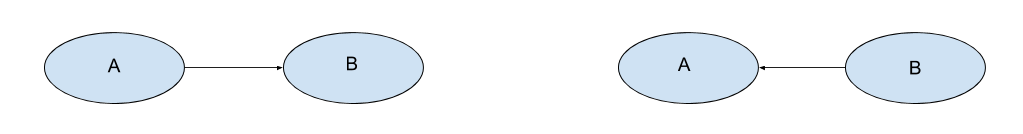

In the above two cases it is fairly obvious that change in any of the node will affect the other. For the first case we can take the example of $difficulty \rightarrow grade$. If we increase the difficulty of the course the probability of getting a higher grade decreases. For the second case we can take the example of $SAT \leftarrow Intel$. Now if we increase the probability of getting a good score in SAT that would imply that the student is intelligent, hence increasing the probability of $i_1$. Therefore in both the cases shown above any change in the variables leads to change in the other variable.

Now, there are four possible ways of connection between 3 nodes: 
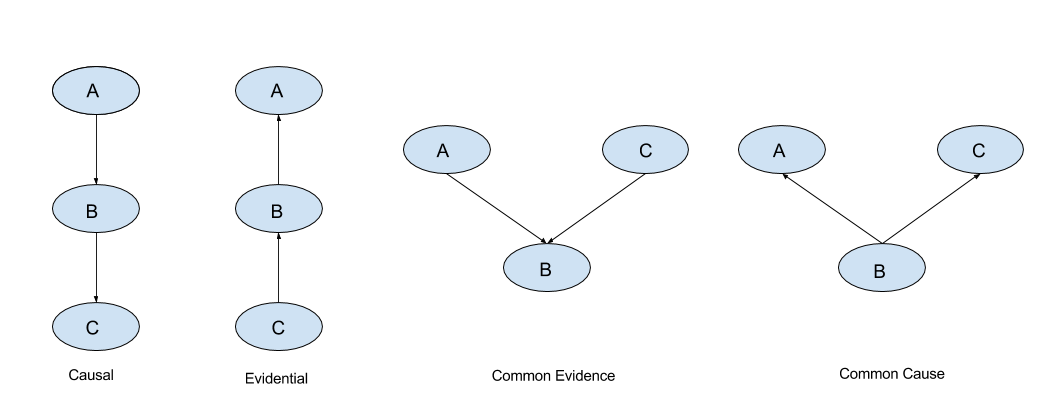

Now in the above cases we will see the flow of influence from $A$ to $C$ under various cases.

(1) __Causal:__ $(A \perp C | B)$

In the general case when we make any changes in the variable $A$, it will have effect of variable $B$ (as we discussed above) and this change in $B$ will change the values in $C$. One other possible case can be when $B$ is observed i.e. we know the value of $B$. So, in this case any change in $A$ won't affect $B$ since we already know the value. And hence there won't be any change in $C$ as it depends only on $B$. 

(2) __Evidential:__ $(A \perp C | B)$

Similarly in this case also observing $B$ renders $C$ independent of $A$. Otherwise when $B$ is not observed the influence flows from $A$ to $C$.

(3) __Common Evidence:__  $(A \perp C)$ (Note: $( A \not\perp C | B)$)

This case is a bit different from the others. When $B$ is not observed any change in $A$ reflects some change in $B$ but not in $C$. Let's take the example of $D \rightarrow G \leftarrow I$. In this case if we increase the difficulty of the course the probability of getting a higher grade reduces but this has no effect on the intelligence of the student. But when $B$ is observed let's say that the student got a good grade. Now if we increase the difficulty of the course this will increase the probability of the student to be intelligent since we already know that he got a good grade. 

(4) __Common Cause:__ $( A \perp C | B)$

The influence flows from $A$ to $C$ when $B$ is not observed. But when $B$ is observed and change in $A$ doesn't affect $C$ since it's only dependent on $B$.

These structures and the associated conditional independencies form the basis of global independencies in a Bayesian Network. They allow us to make inferences about the relationships between different variables in the network, even if they are not directly connected. This is crucial for efficient probabilistic inference in Bayesian Networks.

Let's not see a few examples for finding the independencies in a newtork using pgmpy:

In [6]:
# Getting the local independencies of a variable.
model.local_independencies('G')

(G ⟂ S | D, I)

In [7]:
# Getting all the local independencies in the network.
model.local_independencies(['D', 'I', 'S', 'G', 'L'])

(D ⟂ S, I)
(I ⟂ D)
(S ⟂ D, G, L | I)
(G ⟂ S | D, I)
(L ⟂ D, S, I | G)

**Active trail**: For any two variables A and B in a network if any change in A influences the values of B then we say that there is an active trail between A and B.

In pgmpy, active_trail_nodes gives a set of nodes which are affected (i.e. correlated) by any change in the node passed in the argument.

In [8]:
model.active_trail_nodes('D')

{'D': {'D', 'G', 'L'}}

In [9]:
model.active_trail_nodes('D', observed='G')

{'D': {'D', 'I', 'S'}}

### 1.3 How is this Bayesian Network representing the Joint Distribution over the variables ?
Till now we just have been considering that the Bayesian Network can represent the Joint Distribution without any proof. Now let's see how to compute the Joint Distribution from the Bayesian Network.

From the chain rule of probabiliy we know that:

$P(A, B) = P(A | B) * P(B)$

Now in this case:

$P(D, I, G, L, S) = P(L| S, G, D, I) * P(S | G, D, I) * P(G | D, I) * P(D | I) * P(I)$

Applying the local independence conditions in the above equation we will get:

$P(D, I, G, L, S) = P(L|G) * P(S|I) * P(G| D, I) * P(D) * P(I)$

From the above equation we can clearly see that the Joint Distribution over all the variables is just the product of all the CPDs in the network. Hence **encoding the independencies** in the Joint Distribution in a graph structure helped us in **reducing the number of parameters** that we need to store.

### 1.4 Inference in Bayesian Models
Till now we discussed just about representing Bayesian Networks. Now let's see how we can do inference in a Bayesian Model and use it to predict values over new data points for machine learning tasks. In this section we will consider that we already have our model. We will talk about constructing the models from data in later parts of this tutorial.

In inference we try to answer probability queries over the network given some other variables. So, we might want to know the probable grade of an intelligent student in a difficult class given that he scored good in SAT. So for computing these values from a Joint Distribution we will have to reduce over the given variables that is $I = 1$, $D = 1$, $S = 1$ and then marginalize over the other variables that is $L$ to get $P(G | I=1, D=1, S=1)$.
But carrying on marginalize and reduce operation on the complete Joint Distribution is computationaly expensive since we need to iterate over the whole table for each operation and the table is exponential is size to the number of variables. But in Graphical Models we exploit the independencies to break these operations in smaller parts making it much faster.

One of the very basic methods of inference in Graphical Models is __Variable Elimination__.

#### Variable Elimination
We know that:

$P(D, I, G, L, S) = P(L|G) * P(S|I) * P(G|D, I) * P(D) * P(I)$

Now let's say we just want to compute the probability of G. For that we will need to marginalize over all the other variables.

$P(G) = \sum_{D, I, L, S} P(D, I, G, L, S)$

$P(G) = \sum_{D, I, L, S} P(L|G) * P(S|I) * P(G|D, I) * P(D) * P(I)$

$P(G) = \sum_D \sum_I \sum_L \sum_S P(L|G) * P(S|I) * P(G|D, I) * P(D) * P(I)$

Now since not all the conditional distributions depend on all the variables we can push the summations inside:

$P(G) = \sum_D \sum_I \sum_L \sum_S P(L|G) * P(S|I) * P(G|D, I) * P(D) * P(I)$

$P(G) = \sum_D P(D) \sum_I P(G|D, I) * P(I) \sum_S P(S|I) \sum_L P(L|G)$

So, by pushing the summations inside we have saved a lot of computation because we have to now iterate over much smaller tables.

Let's take an example for inference using Variable Elimination in pgmpy:

In [10]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)
g_dist = infer.query(['G'])
print(g_dist)

+------+----------+
| G    |   phi(G) |
+======+==========+
| G(A) |   0.3620 |
+------+----------+
| G(B) |   0.2884 |
+------+----------+
| G(C) |   0.3496 |
+------+----------+


There can be cases in which we want to compute the conditional distribution let's say $P(G | D=0, I=1)$. In such cases we need to modify our equations a bit:

$P(G | D=0, I=1) = \sum_L \sum_S P(L|G) * P(S| I=1) * P(G| D=0, I=1) * P(D=0) * P(I=1)$

$P(G | D=0, I=1) = P(D=0) * P(I=1) * P(G | D=0, I=1) * \sum_L P(L | G) * \sum_S P(S | I=1)$

In pgmpy we will just need to pass an extra argument in the case of conditional distributions:

In [11]:
print(infer.query(['G'], evidence={'D': 'Easy', 'I': 'Intelligent'}))

+------+----------+
| G    |   phi(G) |
+======+==========+
| G(A) |   0.9000 |
+------+----------+
| G(B) |   0.0800 |
+------+----------+
| G(C) |   0.0200 |
+------+----------+


####  Predicting values from new data points
Predicting values from new data points is quite similar to computing the conditional probabilities. We need to query for the variable that we need to predict given all the other features. The only difference is that rather than getting the probabilitiy distribution we are interested in getting the most probable state of the variable.

In pgmpy this is known as MAP query. Here's an example:

In [12]:
infer.map_query(['G'])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'G': 'A'}

In [13]:
infer.map_query(['G'], evidence={'D': 'Hard', 'I': 'Dumb'})

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'G': 'C'}

In [14]:
infer.map_query(['G'], evidence={'D': 'Easy', 'I': 'Dumb'})

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'G': 'B'}

In [15]:
infer.map_query(['G'], evidence={'D': 'Hard', 'I': 'Intelligent', 'L': 'Good', 'S': 'Good'})

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'G': 'A'}

## 2. Learning Bayesian Networks from Data

This section will be about obtaining a Bayesian network given a set of sample data. Learning a Bayesian network can be split into two problems:

 **Parameter learning:** Given a set of data samples and a DAG that captures the dependencies between the variables, estimate the (conditional) probability distributions of the individual variables.
 
 **Structure learning:** Given a set of data samples, estimate a DAG that captures the dependencies between the variables.
 
This notebook aims to illustrate how parameter learning and structure learning can be done with pgmpy.
Currently, the library supports:
 - Parameter learning for *discrete* nodes:
   - Maximum Likelihood Estimation
   - Bayesian Estimation
 - Structure learning for *discrete*, *fully observed* networks:
   - Score-based structure estimation (BIC/BDeu/K2 score; exhaustive search, hill climb/tabu search)
   - Constraint-based structure estimation (PC)
   - Hybrid structure estimation (MMHC)


### 2.1 Parameter Learning

Suppose we have the following data:

In [16]:
import pandas as pd
data = pd.DataFrame(data={'fruit': ["banana", "apple", "banana", "apple", "banana","apple", "banana", 
                                    "apple", "apple", "apple", "banana", "banana", "apple", "banana",], 
                          'tasty': ["yes", "no", "yes", "yes", "yes", "yes", "yes", 
                                    "yes", "yes", "yes", "yes", "no", "no", "no"], 
                          'size': ["large", "large", "large", "small", "large", "large", "large",
                                    "small", "large", "large", "large", "large", "small", "small"]})
print(data)

     fruit tasty   size
0   banana   yes  large
1    apple    no  large
2   banana   yes  large
3    apple   yes  small
4   banana   yes  large
5    apple   yes  large
6   banana   yes  large
7    apple   yes  small
8    apple   yes  large
9    apple   yes  large
10  banana   yes  large
11  banana    no  large
12   apple    no  small
13  banana    no  small


We know that the variables relate as follows:

In [17]:
from pgmpy.models import BayesianNetwork

model = BayesianNetwork([('fruit', 'tasty'), ('size', 'tasty')])  # fruit -> tasty <- size

Parameter learning is the task to estimate the values of the conditional probability distributions (CPDs), for the variables `fruit`, `size`, and `tasty`. 

#### State counts
To make sense of the given data, we can start by counting how often each state of the variable occurs. If the variable is dependent on parents, the counts are done conditionally on the parents states, i.e. for seperately for each parent configuration:

In [18]:
from pgmpy.estimators import ParameterEstimator
pe = ParameterEstimator(model, data)
print("\n", pe.state_counts('fruit'))  # unconditional
print("\n", pe.state_counts('tasty'))  # conditional on fruit and size


         count
fruit        
apple       7
banana      7

 fruit apple       banana      
size  large small  large small
tasty                         
no      1.0   1.0    1.0   1.0
yes     3.0   2.0    5.0   0.0


We can see, for example, that as many apples as bananas were observed and that `5` large bananas were tasty, while only `1` was not.

#### Maximum Likelihood Estimation

A natural estimate for the CPDs is to simply use the *relative frequencies*, with which the variable states have occured. We observed `7 apples` among a total of `14 fruits`, so we might guess that about `50%` of `fruits` are `apples`.

This approach is *Maximum Likelihood Estimation (MLE)*. According to MLE, we should fill the CPDs in such a way, that $P(\text{data}|\text{model})$ is maximal. This is achieved when using the *relative frequencies*. Pgmpy supports MLE as follows:

In [19]:
from pgmpy.estimators import MaximumLikelihoodEstimator
mle = MaximumLikelihoodEstimator(model, data)
print(mle.estimate_cpd('fruit'))  # unconditional
print(mle.estimate_cpd('tasty'))  # conditional

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+------------+--------------+-----+---------------+
| fruit      | fruit(apple) | ... | fruit(banana) |
+------------+--------------+-----+---------------+
| size       | size(large)  | ... | size(small)   |
+------------+--------------+-----+---------------+
| tasty(no)  | 0.25         | ... | 1.0           |
+------------+--------------+-----+---------------+
| tasty(yes) | 0.75         | ... | 0.0           |
+------------+--------------+-----+---------------+


`mle.estimate_cpd(variable)` computes the state counts and divides each cell by the (conditional) sample size. The `mle.get_parameters()`-method returns a list of CPDs for all variable of the model.

The built-in `fit()`-method of `BayesianModel` provides more convenient access to parameter estimators:


In [20]:
# Calibrate all CPDs of `model` using MLE:
model.fit(data, estimator=MaximumLikelihoodEstimator)


While very straightforward, the ML estimator has the problem of *overfitting* to the data. In above CPD, the probability of a large banana being tasty is estimated at `0.833`, because `5` out of `6` observed large bananas were tasty. Fine. But note that the probability of a small banana being tasty is estimated at `0.0`, because we  observed only one small banana and it happened to be not tasty. But that should hardly make us certain that small bananas aren't tasty!
We simply do not have enough observations to rely on the observed frequencies. If the observed data is not representative for the underlying distribution, ML estimations will be extremly far off. 

When estimating parameters for Bayesian networks, lack of data is a frequent problem. Even if the total sample size is very large, the fact that state counts are done conditionally for each parents configuration causes immense fragmentation. If a variable has 3 parents that can each take 10 states, then state counts will be done seperately for `10^3 = 1000` parents configurations. This makes MLE very fragile and unstable for learning Bayesian Network parameters. A way to mitigate MLE's overfitting is *Bayesian Parameter Estimation*.

#### Bayesian Parameter Estimation

The Bayesian Parameter Estimator starts with already existing prior CPDs, that express our beliefs about the variables *before* the data was observed. Those "priors" are then updated, using the state counts from the observed data.

One can think of the priors as consisting in *pseudo state counts*, that are added to the actual counts before normalization.
Unless one wants to encode specific beliefs about the distributions of the variables, one commonly chooses **uniform priors**, i.e. ones that deem all states equiprobable.

A very simple prior is the so-called *K2* prior, which simply adds `1` to the count of every single state.
A somewhat more sensible choice of prior is *BDeu* (Bayesian Dirichlet equivalent uniform prior). For BDeu we need to specify an *equivalent sample size* `N` and then the pseudo-counts are the equivalent of having observed `N` uniform samples of each variable (and each parent configuration). In pgmpy:

In [21]:
from pgmpy.estimators import BayesianEstimator
est = BayesianEstimator(model, data)

print(est.estimate_cpd('tasty', prior_type='BDeu', equivalent_sample_size=10))

+------------+---------------------+-----+---------------------+
| fruit      | fruit(apple)        | ... | fruit(banana)       |
+------------+---------------------+-----+---------------------+
| size       | size(large)         | ... | size(small)         |
+------------+---------------------+-----+---------------------+
| tasty(no)  | 0.34615384615384615 | ... | 0.6428571428571429  |
+------------+---------------------+-----+---------------------+
| tasty(yes) | 0.6538461538461539  | ... | 0.35714285714285715 |
+------------+---------------------+-----+---------------------+


The estimated values in the CPDs are now more conservative. In particular, the estimate for a small banana being not tasty is now around `0.64` rather than `1.0`. Setting `equivalent_sample_size` to `10` means that for each parent configuration, we add the equivalent of 10 uniform samples (here: `+5` small bananas that are tasty and `+5` that aren't).

`BayesianEstimator`, too, can be used via the `fit()`-method. Full example:

In [22]:
import numpy as np
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator

# generate data
data = pd.DataFrame(data={'fruit': ["banana", "apple", "banana", "apple", "banana","apple", "banana", 
                                    "apple", "apple", "apple", "banana", "banana", "apple", "banana",], 
                          'tasty': ["yes", "no", "yes", "yes", "yes", "yes", "yes", 
                                    "yes", "yes", "yes", "yes", "no", "no", "no"], 
                          'size': ["large", "large", "large", "small", "large", "large", "large",
                                    "small", "large", "large", "large", "large", "small", "small"]})
model = BayesianNetwork([('fruit', 'tasty'), ('size', 'tasty')])  # fruit -> tasty <- size

model.fit(data, estimator=BayesianEstimator, prior_type="BDeu") # default equivalent_sample_size=5
for cpd in model.get_cpds():
    print(cpd)

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+------------+---------------------+-----+--------------------+
| fruit      | fruit(apple)        | ... | fruit(banana)      |
+------------+---------------------+-----+--------------------+
| size       | size(large)         | ... | size(small)        |
+------------+---------------------+-----+--------------------+
| tasty(no)  | 0.30952380952380953 | ... | 0.7222222222222222 |
+------------+---------------------+-----+--------------------+
| tasty(yes) | 0.6904761904761905  | ... | 0.2777777777777778 |
+------------+---------------------+-----+--------------------+
+-------------+----------+
| size(large) | 0.657895 |
+-------------+----------+
| size(small) | 0.342105 |
+-------------+----------+


### 2.2 Structure Learning

To learn model structure (a DAG) from a data set, there are two broad techniques:

 - score-based structure learning
 - constraint-based structure learning

The combination of both techniques allows further improvement:
 - hybrid structure learning

We briefly discuss all approaches and give examples.

### Score-based Structure Learning


This approach construes model selection as an optimization task. It has two building blocks:

- A _scoring function_ $s_D\colon M \to \mathbb R$ that maps models to a numerical score, based on how well they fit to a given data set $D$.
- A _search strategy_ to **traverse the search space of possible models** $M$ and select a model with optimal score.


#### Scoring functions

Commonly used scores to measure the fit between model and data are _Bayesian Dirichlet scores_ such as *BDeu* or *K2* and the _Bayesian Information Criterion_ (BIC, also called MDL). See [1], Section 18.3 for a detailed introduction on scores. As before, BDeu is dependent on an equivalent sample size.

In [23]:
import pandas as pd
import numpy as np
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianNetwork

# create random data sample with 3 variables, where Z is dependent on X, Y:
data = pd.DataFrame(np.random.randint(0, 4, size=(5000, 2)), columns=list('XY'))
data['Z'] = data['X'] + data['Y']

bdeu = BDeuScore(data, equivalent_sample_size=5)
k2 = K2Score(data)
bic = BicScore(data)

model1 = BayesianNetwork([('X', 'Z'), ('Y', 'Z')])  # X -> Z <- Y
model2 = BayesianNetwork([('X', 'Z'), ('X', 'Y')])  # Y <- X -> Z


print(bdeu.score(model1))
print(k2.score(model1))
print(bic.score(model1))

print(bdeu.score(model2))
print(k2.score(model2))
print(bic.score(model2))


-13938.131592366011
-14328.974059127951
-14294.168819877386
-20906.11708175175
-20932.94833139822
-20950.157542167944


While the scores vary slightly, we can see that the correct `model1` has a much higher score than `model2`.
Importantly, these scores _decompose_, i.e. they can be computed locally for each of the variables given their potential parents, independent of other parts of the network:

In [24]:
print(bdeu.local_score('Z', parents=[]))
print(bdeu.local_score('Z', parents=['X']))
print(bdeu.local_score('Z', parents=['X', 'Y']))

-9222.022970687152
-6993.1720108986665
-57.12179755120013


#### Search strategies
The search space of DAGs is super-exponential in the number of variables and the above scoring functions allow for local maxima. The first property makes exhaustive search intractable for all but very small networks, the second prohibits efficient local optimization algorithms to always find the optimal structure. Thus, identifiying the ideal structure is often not tractable. Despite these bad news, heuristic search strategies often yields good results.

If only few nodes are involved (less than 5), `ExhaustiveSearch` can be used to compute the score for every DAG and returns the best-scoring one:

In [25]:
from pgmpy.estimators import ExhaustiveSearch

es = ExhaustiveSearch(data, scoring_method=bic)
best_model = es.estimate()
print(best_model.edges())

print("\nAll DAGs by score:")
for score, dag in reversed(es.all_scores()):
    print(score, dag.edges())

[('X', 'Z'), ('Y', 'Z')]

All DAGs by score:
-14294.168819877386 [('X', 'Z'), ('Y', 'Z')]
-14330.203074930807 [('Y', 'X'), ('Z', 'X'), ('Z', 'Y')]
-14330.203074930807 [('X', 'Z'), ('Y', 'Z'), ('Y', 'X')]
-14330.203074930807 [('X', 'Y'), ('Z', 'X'), ('Z', 'Y')]
-14330.203074930807 [('X', 'Y'), ('X', 'Z'), ('Z', 'Y')]
-14330.203074930809 [('Y', 'Z'), ('Y', 'X'), ('Z', 'X')]
-14330.203074930809 [('X', 'Y'), ('X', 'Z'), ('Y', 'Z')]
-16525.27808661634 [('Y', 'X'), ('Z', 'X')]
-16527.336980859356 [('X', 'Y'), ('Z', 'Y')]
-18719.048275428988 [('Z', 'X'), ('Z', 'Y')]
-18719.048275428988 [('X', 'Z'), ('Z', 'Y')]
-18719.04827542899 [('Y', 'Z'), ('Z', 'X')]
-20914.123287114522 [('Z', 'X')]
-20914.123287114522 [('X', 'Z')]
-20916.182181357537 [('Z', 'Y')]
-20916.182181357537 [('Y', 'Z')]
-20950.15754216794 [('X', 'Z'), ('Y', 'X')]
-20950.157542167944 [('X', 'Y'), ('Z', 'X')]
-20950.157542167944 [('X', 'Y'), ('X', 'Z')]
-20952.21643641096 [('Y', 'X'), ('Z', 'Y')]
-20952.21643641096 [('Y', 'Z'), ('Y

Once more nodes are involved, one needs to switch to heuristic search. `HillClimbSearch` implements a greedy local search that starts from the DAG `start` (default: disconnected DAG) and proceeds by iteratively performing single-edge manipulations that maximally increase the score. The search terminates once a local maximum is found.

In [26]:
from pgmpy.estimators import HillClimbSearch

# create some data with dependencies
data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']

hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=BicScore(data))
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('A', 'H'), ('A', 'C'), ('A', 'B'), ('B', 'C'), ('G', 'H')]


The search correctly identifies e.g. that `B` and `C` do not influnce `H` directly, only through `A` and of course that `D`, `E`, `F` are independent.


To enforce a wider exploration of the search space, the search can be enhanced with a tabu list. The list keeps track of the last `n` modfications; those are then not allowed to be reversed, regardless of the score. Additionally a `white_list` or `black_list` can be supplied to restrict the search to a particular subset or to exclude certain edges. The parameter `max_indegree` allows to restrict the maximum number of parents for each node.


### Constraint-based Structure Learning

A different, but quite straightforward approach to build a DAG from data is this:

1. Identify independencies in the data set using hypothesis tests 
2. Construct DAG (pattern) according to identified independencies

#### (Conditional) Independence Tests

Independencies in the data can be identified using chi2 conditional independence tests. To this end, a conditional independence hypothesis test is performed to check if `X` is independent from `Y` given a set of variables `Zs`:

In [27]:
from pgmpy.estimators import PC
from pgmpy.estimators.CITests import chi_square

data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']
data['E'] *= data['F']

print(chi_square(X='B', Y='H', Z=[], data=data, significance_level=0.05))          # dependent
print(chi_square(X='B', Y='E', Z=[], data=data, significance_level=0.05))          # independent
print(chi_square(X='B', Y='H', Z=['A'], data=data, significance_level=0.05))       # independent
print(chi_square(X='A', Y='G', Z=[], data=data, significance_level=0.05))          # independent
print(chi_square(X='A', Y='G', Z=['H'], data=data, significance_level=0.05))       # dependent

False
True
True
True
False


The `CITests.py` module in pgmpy implements a few possible conditional independence tests.

#### DAG (pattern) construction

With a method for independence testing at hand, we can construct a DAG from the data set in three steps:
1. Construct an undirected skeleton - `estimate_skeleton()`
2. Orient compelled edges to obtain partially directed acyclid graph (PDAG; I-equivalence class of DAGs) - `skeleton_to_pdag()`
3. Extend DAG pattern to a DAG by conservatively orienting the remaining edges in some way - `pdag_to_dag()`

Step 1.&2. form the so-called PC algorithm, see [2], page 550. PDAGs are `DirectedGraph`s, that may contain both-way edges, to indicate that the orientation for the edge is not determined.

In [28]:
est = PC(data)
skel, seperating_sets = est.build_skeleton(significance_level=0.01)
print("Undirected edges: ", skel.edges())

pdag = est.skeleton_to_pdag(skel, seperating_sets)
print("PDAG edges:       ", pdag.edges())

model = pdag.to_dag()
print("DAG edges:        ", model.edges())

  0%|          | 0/5 [00:00<?, ?it/s]

Undirected edges:  [('A', 'B'), ('A', 'C'), ('A', 'H'), ('E', 'F'), ('G', 'H')]
PDAG edges:        [('A', 'H'), ('C', 'A'), ('G', 'H'), ('B', 'A'), ('E', 'F'), ('F', 'E')]
DAG edges:         [('A', 'H'), ('C', 'A'), ('G', 'H'), ('B', 'A'), ('F', 'E')]


The `estimate()`-method provides a shorthand for the three steps above and directly returns a `BayesianModel`:



In [29]:
print(est.estimate(significance_level=0.01).edges())

  0%|          | 0/5 [00:00<?, ?it/s]

[('A', 'H'), ('C', 'A'), ('G', 'H'), ('B', 'A'), ('F', 'E')]


PC PDAG construction is only guaranteed to work under the assumption that the identified set of independencies is *faithful*, i.e. there exists a DAG that exactly corresponds to it. Spurious dependencies in the data set can cause the reported independencies to violate faithfulness. It can happen that the estimated PDAG does not have any faithful completions (i.e. edge orientations that do not introduce new v-structures). In that case a warning is issued.


### Hybrid Structure Learning

The MMHC algorithm [3] combines the constraint-based and score-based method. It has two parts:

1. Learn undirected graph skeleton using the constraint-based construction procedure MMPC
2. Orient edges using score-based optimization (BDeu score + modified hill-climbing)

We can perform the two steps seperately, more or less as follows:

In [30]:
from pgmpy.estimators import MmhcEstimator
from pgmpy.estimators import BDeuScore

data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']
data['E'] *= data['F']

mmhc = MmhcEstimator(data)
skeleton = mmhc.mmpc()
print("Part 1) Skeleton: ", skeleton.edges())

# use hill climb search to orient the edges:
hc = HillClimbSearch(data)
model = hc.estimate(tabu_length=10, white_list=skeleton.to_directed().edges(), scoring_method=BDeuScore(data))
print("Part 2) Model:    ", model.edges())

Part 1) Skeleton:  [('A', 'B'), ('A', 'H'), ('A', 'C'), ('A', 'D'), ('A', 'F'), ('B', 'E'), ('C', 'F'), ('C', 'D'), ('D', 'E'), ('E', 'F'), ('E', 'H'), ('F', 'G'), ('G', 'H')]


  0%|          | 0/1000000 [00:00<?, ?it/s]

Part 2) Model:     [('A', 'H'), ('A', 'B'), ('A', 'C'), ('E', 'F'), ('G', 'H')]


`MmhcEstimator.estimate()` is a shorthand for both steps and directly estimates a `BayesianModel`.

### References

[1] Koller & Friedman, Probabilistic Graphical Models - Principles and Techniques, 2009

[2] Neapolitan, [Learning Bayesian Networks](http://www.cs.technion.ac.il/~dang/books/Learning%20Bayesian%20Networks&#40;Neapolitan,%20Richard&#41;.pdf), 2003

[3] Tsamardinos et al., [The max-min hill-climbing BN structure learning algorithm](http://www.dsl-lab.org/supplements/mmhc_paper/paper_online.pdf), 2005



# Part 2. Exercise

## Exercise: Heart Disease Prediction

In this exercise, you are going to build a Bayesian Network on the Heart Disease dataset.
https://drive.google.com/file/d/17vwRLAY8uR-6vWusM5prn08it-BEGp-f/view

- age: age in years
- sex: sex (1 = male; 0 = female)
- cp: chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- trestbps: resting blood pressure (in mm Hg on admission to the hospital)
- chol: serum cholestoral in mg/dl
- fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restecg: resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes’ criteria
- thalach: maximum heart rate achieved
- exang: exercise induced angina (1 = yes; 0 = no)
- oldpeak = ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
- thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
- Heartdisease: It is integer valued from 0 (no presence) to 4.

Then do the below inference:

Give the probability of HeartDisease given the evidence: the resting electrocardiographic results (restecg) is 1 and the chest pain type(cp) is 2.

Your solution here:

Refernce solution:

Before building the Bayesian Network, we find all continuous features by counting the unique values and perform discretization to continuous features on the Heart Disease dataset. 

In [31]:
import csv
import numpy as np
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer

# Load data
heartDisease = pd.read_csv('heart.csv')
heartDisease = heartDisease.replace('?',np.nan)

# Find continuous features
continuous_features = [col for col in heartDisease.columns if len(heartDisease[col].unique()) > 10]

print(f"Continuous Features: {continuous_features}")

# Discretize continuous features
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
heartDisease[continuous_features] = discretizer.fit_transform(heartDisease[continuous_features])

Continuous Features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


/Users/xiao/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


Then, there are two cases to consider: one where you know the relationships between the variables, and one where you must learn the structure and the parameters from data.

- Case 1: With Known Structure
    - If you already know the structure of the Bayesian Network, you can use the MaximumLikelihoodEstimator to learn the parameters of the conditional probability distributions (CPDs) from the data. This estimator assumes that the data is complete and follows the same distribution as the model.
    - The reference code shows an example of how to create a Bayesian Network with a known structure and learn the CPDs using the MaximumLikelihoodEstimator. The structure is based on some domain knowledge and assumptions about the causal relationships among the variables. For example, the code assumes that age, gender, chest pain type, and exercise induced angina are the direct causes of heart disease, and that heart disease influences the resting electrocardiographic results and the serum cholesterol level.
    - You can modify the reference code to use a different structure or a different estimator, such as the BayesianEstimator, which can handle missing data and incorporate prior information.

In [32]:
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork

# Define the structure
model= BayesianNetwork([('age','heartdisease'),('gender','heartdisease'),('exang','heartdisease'),('cp','heartdisease'),('heartdisease','restecg'),('heartdisease','chol')])

# Learn the parameters
model.fit(heartDisease, estimator=MaximumLikelihoodEstimator)

In [33]:
from pgmpy.inference import VariableElimination

# Create an inference object
infer = VariableElimination(model)

# Define the evidence
evidence = {'restecg': 1, 'cp': 2}

# Perform inference
print('\nProbability of HeartDisease given evidence= ' + str(evidence))
q = infer.query(variables=['heartdisease'], evidence=evidence)
print(q)

# Make the prediction
print(infer.map_query(variables=['heartdisease'], evidence=evidence))


Probability of HeartDisease given evidence= {'restecg': 1, 'cp': 2}
+-----------------+---------------------+
| heartdisease    |   phi(heartdisease) |
+=================+=====================+
| heartdisease(0) |              0.4989 |
+-----------------+---------------------+
| heartdisease(1) |              0.0000 |
+-----------------+---------------------+
| heartdisease(2) |              0.2127 |
+-----------------+---------------------+
| heartdisease(3) |              0.1937 |
+-----------------+---------------------+
| heartdisease(4) |              0.0947 |
+-----------------+---------------------+


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'heartdisease': 0}


- Case 2: Unknown structure
    - If you do not know the structure of the Bayesian Network, you can use a structure learning algorithm to discover it from the data. There are different types of structure learning algorithms, such as constraint-based, score-based, or hybrid methods. These algorithms use different criteria and techniques to find the optimal or near-optimal structure that fits the data best.
    - The pgmpy library provides several structure learning algorithms, such as PC, Hill-Climb Search, and Exhaustive Search. You can use them to learn the structure and the parameters of the Bayesian Network from the data. The reference code shows an example of how to use the PC algorithm, which is a constraint-based method that uses conditional independence tests to find the skeleton and the v-structures of the network. You can modify the reference code to use a different algorithm or a different conditional independence test, such as the G-squared test or the Pearsonr test.

In [34]:
import numpy as np
import pandas as pd
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator
from pgmpy.models import BayesianModel

# Learn the structure
hc = HillClimbSearch(heartDisease)
best_model_structure = hc.estimate(scoring_method=BicScore(heartDisease))

# Convert the learned structure to a BayesianModel
best_model = BayesianNetwork(best_model_structure.edges())

# Learn the parameters
best_model.fit(heartDisease, estimator=MaximumLikelihoodEstimator)

# Print the edges of the model
print("\nEdges in the model:")
for edge in best_model.edges():
    print(edge)

  0%|          | 0/1000000 [00:00<?, ?it/s]


Edges in the model:
('thalach', 'slope')
('thalach', 'age')
('slope', 'oldpeak')
('exang', 'cp')
('exang', 'thalach')
('thal', 'heartdisease')
('thal', 'gender')
('heartdisease', 'exang')
('heartdisease', 'ca')


In [35]:
from pgmpy.inference import VariableElimination

# Create an inference object
infer = VariableElimination(best_model)

# Define the evidence
evidence = {'restecg': 1, 'cp': 2}

# Remove evidence variables not in the model
evidence_ = {var: val for var, val in evidence.items() if var in best_model.nodes()}

# Perform inference
print('\nProbability of HeartDisease given evidence= ' + str(evidence))
q = infer.query(variables=['heartdisease'], evidence=evidence_)
print(q)

# Make the prediction
print(infer.map_query(variables=['heartdisease'], evidence=evidence_))


Probability of HeartDisease given evidence= {'restecg': 1, 'cp': 2}
+-----------------+---------------------+
| heartdisease    |   phi(heartdisease) |
+=================+=====================+
| heartdisease(0) |              0.6484 |
+-----------------+---------------------+
| heartdisease(1) |              0.1580 |
+-----------------+---------------------+
| heartdisease(2) |              0.0820 |
+-----------------+---------------------+
| heartdisease(3) |              0.0745 |
+-----------------+---------------------+
| heartdisease(4) |              0.0372 |
+-----------------+---------------------+


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'heartdisease': 0}


In [36]:
# Additional code for accuracy test
# Since it is just for demonstration, the dataset has not been splited to training/testing datasets in advance.

from sklearn.metrics import accuracy_score

# Define the test dataset
test_data = heartDisease.head(100)
actual_values = test_data['heartdisease']
test_data = test_data.drop(['heartdisease'], axis=1)

# Create an inference object
infer = VariableElimination(best_model)

# Predict the 'heartdisease' column
predictions = []
for index, data_point in test_data.iterrows():
    evidence = data_point.to_dict()
    evidence_ = {var: val for var, val in evidence.items() if var in best_model.nodes() and pd.isna(val)==False}
    print(evidence_)
    prediction = infer.map_query(variables=['heartdisease'], evidence=evidence_)
    predictions.append(prediction['heartdisease'])

# Calculate the accuracy
accuracy = accuracy_score(actual_values, predictions)

{'age': 2.0, 'gender': 1, 'cp': 1, 'thalach': 1.0, 'exang': 0, 'oldpeak': 1.0, 'slope': 3, 'ca': '0', 'thal': '6'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 1, 'cp': 4, 'thalach': 0.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 2, 'ca': '3', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 1, 'oldpeak': 1.0, 'slope': 2, 'ca': '2', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 0.0, 'gender': 1, 'cp': 3, 'thalach': 2.0, 'exang': 0, 'oldpeak': 1.0, 'slope': 3, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 0.0, 'gender': 0, 'cp': 2, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 2, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 0, 'cp': 4, 'thalach': 2.0, 'exang': 0, 'oldpeak': 1.0, 'slope': 3, 'ca': '2', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 0, 'cp': 4, 'thalach': 2.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 2, 'ca': '1', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 1, 'oldpeak': 1.0, 'slope': 3, 'ca': '0', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 2, 'ca': '0', 'thal': '6'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 0, 'cp': 2, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 2, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 3, 'thalach': 1.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 2, 'ca': '1', 'thal': '6'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 0.0, 'gender': 1, 'cp': 2, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 3, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 3, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 2, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 3, 'ca': '0', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 0, 'cp': 3, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 2, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 1, 'cp': 1, 'thalach': 1.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 2, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 0, 'cp': 1, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 2, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 2, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 3, 'thalach': 2.0, 'exang': 0, 'oldpeak': 1.0, 'slope': 1, 'ca': '2', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 1, 'oldpeak': 1.0, 'slope': 2, 'ca': '2', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 0, 'cp': 3, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 2, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 0, 'cp': 3, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 0, 'cp': 1, 'thalach': 0.0, 'exang': 0, 'oldpeak': 1.0, 'slope': 3, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 0.0, 'gender': 1, 'cp': 4, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 0.0, 'gender': 1, 'cp': 4, 'thalach': 0.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 2, 'ca': '0', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 0, 'cp': 1, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '2', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 2.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 1, 'ca': '2', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 1, 'cp': 3, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 2, 'ca': '0', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 0.0, 'gender': 1, 'cp': 3, 'thalach': 2.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 0.0, 'gender': 1, 'cp': 4, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 0.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 1, 'oldpeak': 1.0, 'slope': 2, 'ca': '0', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 0.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 2, 'ca': '1', 'thal': '6'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 2, 'ca': '1', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 1, 'cp': 3, 'thalach': 1.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 2, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 0, 'cp': 4, 'thalach': 0.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 2, 'ca': '3', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 0.0, 'gender': 1, 'cp': 1, 'thalach': 2.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 0, 'cp': 2, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '2', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 3, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 0, 'cp': 4, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 3, 'thalach': 2.0, 'exang': 0, 'oldpeak': 1.0, 'slope': 2, 'ca': '1', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 3, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 0, 'oldpeak': 1.0, 'slope': 2, 'ca': '0', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 0, 'cp': 3, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '1', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 3, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 3, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 0.0, 'gender': 0, 'cp': 2, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '1', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 0.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '1', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 0.0, 'gender': 1, 'cp': 2, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 1, 'ca': '1', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 0.0, 'exang': 1, 'oldpeak': 1.0, 'slope': 2, 'ca': '1', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 3, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 2, 'ca': '1', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 0.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 3, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 3, 'ca': '1', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 1, 'thalach': 1.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 1, 'ca': '1', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 0, 'cp': 4, 'thalach': 1.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 2, 'ca': '0', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 0, 'cp': 3, 'thalach': 2.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 3, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 1, 'oldpeak': 1.0, 'slope': 2, 'ca': '3', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 0, 'cp': 3, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 0.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 2, 'ca': '1', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 1, 'oldpeak': 1.0, 'slope': 2, 'ca': '2', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 3, 'thalach': 1.0, 'exang': 0, 'oldpeak': 1.0, 'slope': 2, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 3, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 1, 'oldpeak': 1.0, 'slope': 3, 'ca': '0', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 3, 'thalach': 1.0, 'exang': 0, 'oldpeak': 1.0, 'slope': 2, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 0, 'cp': 3, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 1, 'cp': 4, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 2, 'ca': '2', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 1, 'cp': 4, 'thalach': 0.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 2, 'ca': '2', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '2', 'thal': '6'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 0.0, 'gender': 1, 'cp': 4, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '1', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 0, 'cp': 3, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 1, 'oldpeak': 1.0, 'slope': 2, 'ca': '1', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 0, 'cp': 3, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '1', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 2, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 2, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 0.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 1, 'oldpeak': 1.0, 'slope': 2, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 0, 'cp': 4, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 2, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 0.0, 'gender': 1, 'cp': 3, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 1, 'cp': 3, 'thalach': 1.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 2, 'ca': '0', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 2, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 0.0, 'gender': 1, 'cp': 3, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 3, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 0, 'cp': 3, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0'}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'age': 1.0, 'gender': 0, 'cp': 4, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 0, 'cp': 3, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 2, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 0, 'cp': 4, 'thalach': 1.0, 'exang': 0, 'oldpeak': 2.0, 'slope': 3, 'ca': '3', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 1, 'cp': 3, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 2, 'ca': '3', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 0.0, 'gender': 0, 'cp': 3, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 2, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 2.0, 'gender': 0, 'cp': 3, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 2.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 1, 'ca': '1', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 1.0, 'exang': 1, 'oldpeak': 0.0, 'slope': 2, 'ca': '1', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 0, 'cp': 4, 'thalach': 1.0, 'exang': 0, 'oldpeak': 1.0, 'slope': 2, 'ca': '2', 'thal': '7'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 2, 'thalach': 1.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '1', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'age': 1.0, 'gender': 1, 'cp': 4, 'thalach': 2.0, 'exang': 0, 'oldpeak': 0.0, 'slope': 1, 'ca': '0', 'thal': '3'}


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [37]:
# Print the accuracy
print(f"The accuracy of the model is {accuracy}")

The accuracy of the model is 0.62


# Part 3. Template for Assignment 8

```
import os
import numpy as np
import pandas as pd

def read_data_from_csv(path):
    """Load datasets from CSV files.
    Args:
        path (str): Path to the CSV file.
    Returns:
        X (np.ndarray): Features of samples.
        y (np.ndarray): Labels of samples, only provided in the public datasets.
    """
    assert os.path.exists(path), f'File not found: {path}!'
    assert os.path.splitext(path)[
        -1] == '.csv', f'Unsupported file type {os.path.splitext(path)[-1]}!'

    data = pd.read_csv(path)
    column_list = data.columns.values.tolist()

    if 'Label' in column_list:
        # for the public dataset, label column is provided.
        column_list.remove('Label')
        X = data[column_list].values
        y = data['Label'].values
        return X, y
    else:
        # for the private dataset, label column is not provided.
        X = data[column_list].values
        return X
    
    
X_public, y_public = read_data_from_csv('assignment_8_public.csv')
print('Shape of X_public:', X_public.shape)  # n_sample, m_feature (6499, 22)
print('Shape of y_public:', y_public.shape)  # n_sample (6499,)

'''
CODE HERE!
'''

X_private = read_data_from_csv('assignment_8_private.csv')
print('Shape of X_private:', X_private.shape)  # k_sample, m_feature (1625, 22)
# remove and make your own predictions.
preds = [' '] * len(X_private)

'''
CODE HERE!
e.g.,
preds = [' '] * len(X_private)
'''

submission = pd.DataFrame({'Label': preds})
submission.to_csv('assignment_8.csv', index=True, index_label='Id')
```